In [1]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
percentages = [0, 25, 50, 75, 100]

path = "../data/2022-11-22_ignore_hydras_logs"
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print("Skipping: ", file_path)
        continue

    print(f"Parsing and dumping: {file_path}")
    parse([file_path])


Parsing and dumping: ../data/2022-11-22_ignore_hydras_logs/nodes-list-wo-75pct-node-1.log
Parsing ../data/2022-11-22_ignore_hydras_logs/nodes-list-wo-75pct-node-1.log
cid QmUAZMhTSHLmWZY1RSeSWqSPxhopd8ad3c6D9dYpGn1zRr find node query already done 12D3KooWGeYidbifwDUAG97twbkrQudfogHfT189stEwkeq5h7Bf (n.a.)
cid QmUAZMhTSHLmWZY1RSeSWqSPxhopd8ad3c6D9dYpGn1zRr find node query already done 12D3KooWN2ER1NzmjqCUuDj23ehtpNCKeGyHhwb1vack3QKiZPqj (n.a.)
cid QmUAZMhTSHLmWZY1RSeSWqSPxhopd8ad3c6D9dYpGn1zRr find node query already done 12D3KooWKwc9ypBxQSmX886pmkGKTrgfmnzBFwi6jRGgCZdZSWHM (n.a.)
cid QmUAZMhTSHLmWZY1RSeSWqSPxhopd8ad3c6D9dYpGn1zRr find node query already done 12D3KooWAusU7fTk4MdC2jsDAxUg9VRxoW2ZkKmEpzNtUmjERLdy (n.a.)
Parsing and dumping: ../data/2022-11-22_ignore_hydras_logs/nodes-list-wo-0pct-node-3.log
Parsing ../data/2022-11-22_ignore_hydras_logs/nodes-list-wo-0pct-node-3.log
not using peer 12D3KooWL8Sam6Zrom6Vt1vyG9EHthm9VMfpRWFfXw2kFPKqanrv (go-ipfs/0.7.0/) for cid QmVEiG9XhuyWr6M

In [4]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]
pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))

In [5]:
results_by_percentages = {}

for idx, f in enumerate(files):
    match = re.search(r".*\/nodes-list-wo-(\d+)pct-node-(\d).log", f)
    percent = int(match.group(1))
    no = match.group(2)
    if not percent in results_by_percentages:
        results_by_percentages[percent] = []
    results_by_percentages[percent] += [results[idx][0]]

In [6]:
retrievals_by_percent_ignored = {}
overall_retrieval_duration_per_region_by_percent_ignored = {}
dht_ret_walks_duration_per_region_by_percent_ignored = {}
dht_ret_find_first_provider_per_region_by_percent_ignored = {}
content_fetch_duration_per_region_by_percent_ignored = {}
retrieval_find_provider_queries_per_region_by_percent_ignored = {}
retrieval_errors_per_region_by_percent_ignored = {}

for percent in percentages:
    parsed_logs = results_by_percentages[percent]

    publications: List[Publication] = []
    retrievals: List[Retrieval] = []
    for parsed_log in parsed_logs:
        publications += parsed_log.publications
        retrievals += parsed_log.retrievals

    # Remove all retrievals that are marked as invalid
    retrievals = list(
        filter(lambda ret: not ret.marked_as_incomplete, retrievals))
    retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

    overall_retrieval_duration_per_region: Dict[str, List[float]] = {}
    dht_ret_walks_duration_per_region: Dict[str, List[float]] = {}
    dht_ret_find_first_provider_per_region: Dict[str, List[float]] = {}
    content_fetch_duration_per_region: Dict[str, List[float]] = {}
    retrieval_find_provider_queries_per_region: Dict[str, List[float]] = {}
    retrieval_errors_per_region: Dict[str, int] = {}

    for ret in retrievals:
        region: Optional[str] = None
        for no in log_no_to_region:
            if f"{no}.log" in ret.origin:
                region = log_no_to_region[no]
        if region is None:
            raise Exception("AHH")

        if ret.stream_opened_at is None or ret.connected_at is None:
            print("skip", ret.stream_opened_at, ret.connected_at)
            continue

        if ret.done_retrieving_error is not None:
            print(f"{ret.cid} in {ret.origin} had error: {ret.done_retrieving_error}")
            if region not in retrieval_errors_per_region:
                retrieval_errors_per_region[region] = 0
            retrieval_errors_per_region[region] += 1

        overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
        # simulate peer record retrieval by adding the DHT walk duration
        overall_retrieval_duration += ret.get_dht_walk_duration()
        if region not in overall_retrieval_duration_per_region:
            overall_retrieval_duration_per_region[region] = []
        overall_retrieval_duration_per_region[region] += [overall_retrieval_duration]

        # simulate peer record retrieval by adding the DHT walk duration
        dht_walk_duration = 2 * ret.get_dht_walk_duration()
        if region not in dht_ret_walks_duration_per_region:
            dht_ret_walks_duration_per_region[region] = []
        dht_ret_walks_duration_per_region[region] += [dht_walk_duration]

        dht_ret_find_first_provider = (
                ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()
        if region not in dht_ret_find_first_provider_per_region:
            dht_ret_find_first_provider_per_region[region] = []
        dht_ret_find_first_provider_per_region[region] += [dht_ret_find_first_provider]

        content_fetch_duration = (ret.done_retrieving_at - ret.dial_started_at).total_seconds()
        if region not in content_fetch_duration_per_region:
            content_fetch_duration_per_region[region] = []
        content_fetch_duration_per_region[region] += [content_fetch_duration]

        if region not in retrieval_find_provider_queries_per_region:
            retrieval_find_provider_queries_per_region[region] = []

        retrieval_find_provider_queries_per_region[region] += [
            len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))
        ]

    overall_retrieval_duration_per_region_by_percent_ignored[percent] = overall_retrieval_duration_per_region
    dht_ret_walks_duration_per_region_by_percent_ignored[percent] = dht_ret_walks_duration_per_region
    dht_ret_find_first_provider_per_region_by_percent_ignored[percent] = dht_ret_find_first_provider_per_region
    content_fetch_duration_per_region_by_percent_ignored[percent] = content_fetch_duration_per_region
    retrieval_find_provider_queries_per_region_by_percent_ignored[percent] = retrieval_find_provider_queries_per_region
    retrieval_errors_per_region_by_percent_ignored[percent] = retrieval_errors_per_region
    retrievals_by_percent_ignored[percent] = retrievals

# fix percentages


skip None 2022-11-18 22:32:00.975919+00:00
skip None 2022-11-19 02:39:16.809866+00:00
skip None 2022-11-19 09:19:59.321212+00:00
skip None 2022-11-19 10:18:50.105743+00:00
skip None 2022-11-19 12:37:31.360240+00:00
skip None 2022-11-19 23:15:04.479068+00:00
skip None 2022-11-20 12:57:23.868933+00:00
skip None 2022-11-20 21:55:06.953940+00:00
skip None 2022-11-20 22:12:59.454742+00:00
skip None 2022-11-21 07:09:46.586018+00:00
Qme1BKyqj1xtPefeDQSm1iBGGSSmerBxpVzmNepHCDzCtF in ../data/2022-11-22_ignore_hydras_logs/nodes-list-wo-0pct-node-3.log had error: context canceled
skip None 2022-11-22 04:34:14.591520+00:00
skip None 2022-11-22 05:09:04.148103+00:00
skip None 2022-11-22 08:23:17.904784+00:00
skip None 2022-11-22 10:22:04.685327+00:00
skip None 2022-11-19 02:38:52.880479+00:00
skip None 2022-11-19 05:24:36.492228+00:00
skip None 2022-11-19 07:29:25.937326+00:00
skip None 2022-11-20 05:14:31.426739+00:00
skip None 2022-11-20 06:08:58.342290+00:00
skip None 2022-11-20 17:23:06.405911+

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

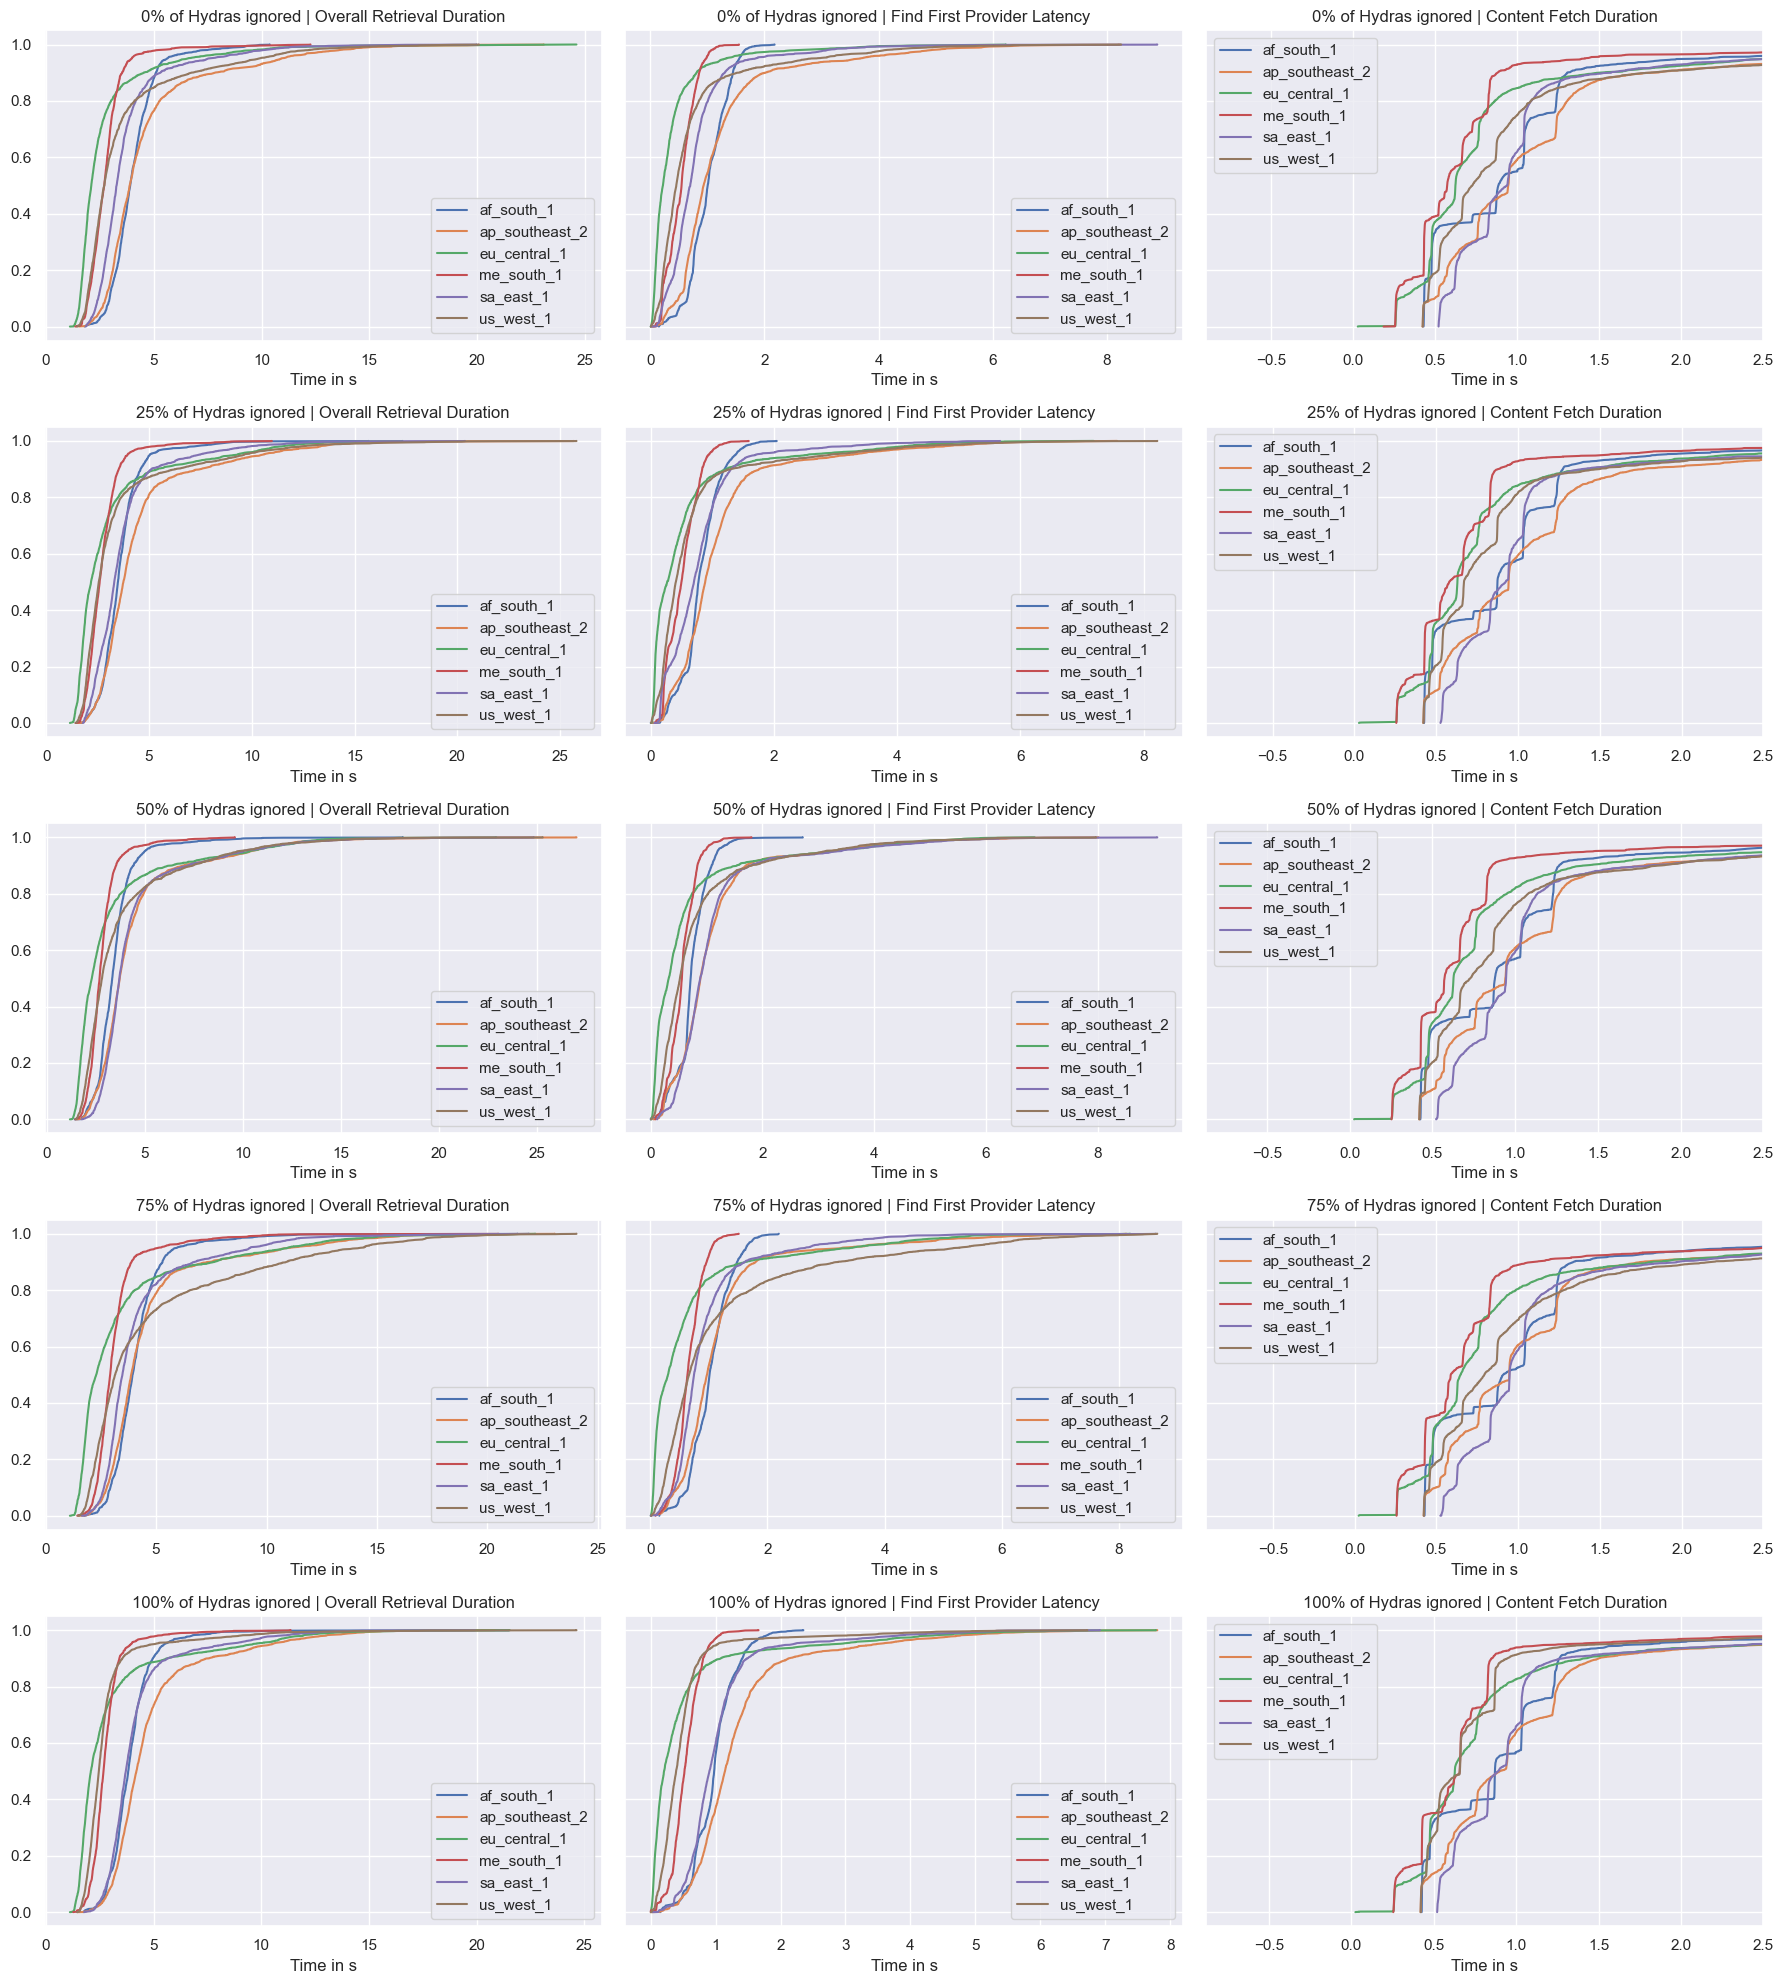

In [9]:
datasets = [
    overall_retrieval_duration_per_region_by_percent_ignored,
    dht_ret_find_first_provider_per_region_by_percent_ignored,
    content_fetch_duration_per_region_by_percent_ignored
]

datasets_labels = ["Overall Retrieval Duration", "Find First Provider Latency", "Content Fetch Duration"]

fig, axes = plt.subplots(len(percentages), len(datasets), figsize=[18, 20], sharey=True)

regions = list(sorted(log_no_to_region.values()))

# I found out that when I thought I'd ignore 75% of hydras I actually on gave a deny list of 25% of hydras
percent_labels = {
    0: 0,
    25: 75,
    50: 50,
    75: 25,
    100:100
}

for i, percent_ignored in enumerate(percent_labels.values()):
    for j, dataset in enumerate(datasets):
        data_by_region = dataset[percent_ignored]
        idx = (i % len(percentages)) * len(datasets) + j
        ax = fig.axes[idx]
        for region in regions:
            data = data_by_region[region]
            data_df = pd.Series(data=data, name="time")
            data_cdf = cdf(data_df)
            ax.plot(data_cdf["time"], data_cdf["cdf"], label=region)
            ax.set_title(f"{percent_labels[percent_ignored]}% of Hydras ignored | {datasets_labels[j]}")
            ax.set_xlabel("Time in s")
        if j== 2:
            ax.set_xlim(xmax=2.5)
        ax.legend()
plt.tight_layout()

50 0 10437
50 75 10664
50 50 10477
50 25 10132
50 100 10805
90 0 10437
90 75 10664
90 50 10477
90 25 10132
90 100 10805
95 0 10437
95 75 10664
95 50 10477
95 25 10132
95 100 10805


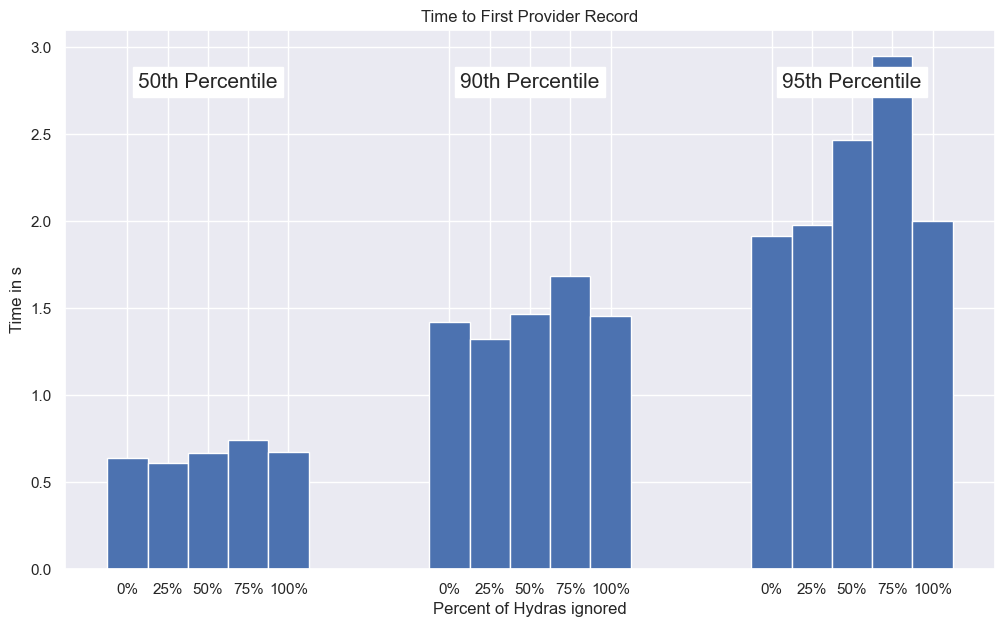

In [10]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.25
xticks = []
labels = []
percentiles = [50, 90, 95]
for i, percentile in enumerate(percentiles):
    for j, percent_ignored in enumerate(percent_labels.values()):
        dat = np.array(list(
            map(lambda ret: (ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds(),
                retrievals_by_percent_ignored[percent_ignored])))

        print(percentile, percent_ignored, len(dat))
        with_percentile = np.percentile(dat, percentile)
        ax.bar(i % len(percentiles) + i + j * width, with_percentile, width, label=f"{percent_ignored}%", color="b")
        xticks += [i % len(percentiles) + i + j * width]
        labels += [f"{percent_labels[percent_ignored]}%"]

    # dat = np.array(list(
    #     map(lambda ret: (ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds(),
    #         retrievals_by_percent_ignored["without"])))
    # without_percentile = np.percentile(dat, percentile)
    # ax.bar(i + width / 2, without_percentile, width, label="Without Hydras", color="r")
    # print(percentile, without_percentile)
    # ax.text(i, without_percentile + 0.1, f"Increase {without_percentile / with_percentile - 1:.1%}", ha="center",
    #         va="center", size=15)
    #
    ax.text(i % len(percentiles) + i + 2 * width, 2.8, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    # xticks += [i - width / 2, i + width / 2]
    # labels += ["With", "Without"]

for j, percent_ignored in enumerate(percent_labels.values()):
    dat = np.array(list(
        map(lambda ret: (ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds(),
            retrievals_by_percent_ignored[percent_ignored])))



ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("Percent of Hydras ignored")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
# ax.set_xlim(-0.5, 2.5)
# ax.set_ylim(0, 3)

Text(0.5, 0, 'With or Without Hydras')

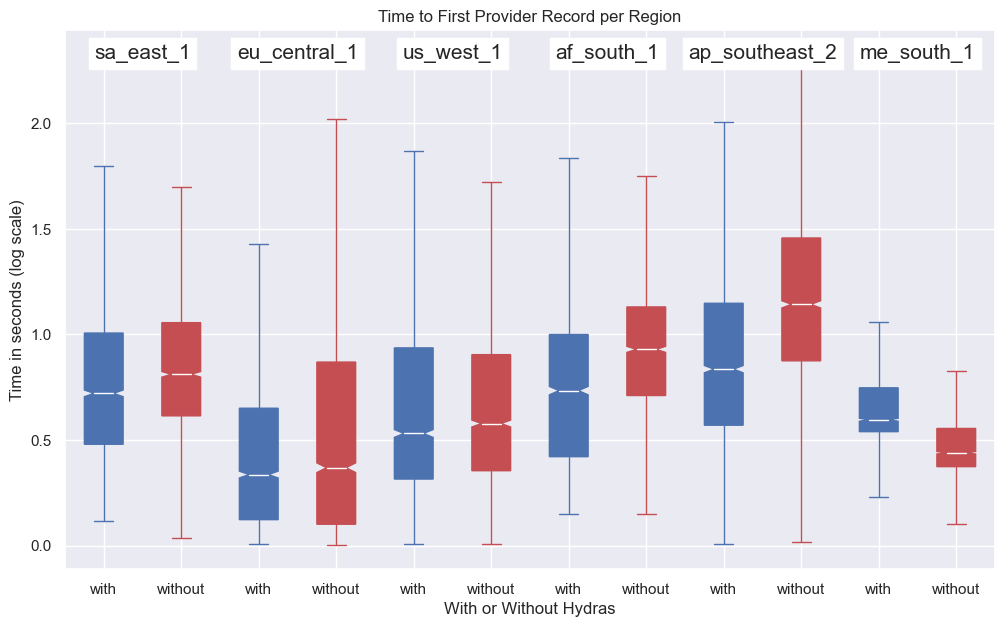

In [11]:
fig, ax = plt.subplots(figsize=[12, 7])

regions = log_no_to_region.values()

dats = []
labels = []
positions = []
for j, region in enumerate(reversed(regions)):
    for i, hydra in enumerate(["with", "without"]):
        dats += [np.array(dht_ret_find_first_provider_per_region_by_hydras[hydra][region])]
        labels += [f"{hydra}"]
    ax.text(2 * j + 1 + 1 / 2, 2.33, region, ha="center", va="center", size=15, bbox=dict(fc="w", lw=1))
bplot = ax.boxplot(dats, notch=True, labels=labels, patch_artist=True, showfliers=False)

colors = ['b', 'r']
for i, patch in enumerate(bplot["boxes"]):
    patch.set_color(colors[i % 2])
    patch.set_facecolor(colors[i % 2])

for i, patch in enumerate(bplot["medians"]):
    patch.set_color("w")

for i, patch in enumerate(bplot["fliers"]):
    patch.set_color("gray")

for item in ["whiskers", "caps"]:
    for i, patch in enumerate(bplot[item]):
        j = i // 2
        patch.set_color(colors[j % 2])

# ax.set_yscale("log")
# ax.set_ylim(ymax=20)
ax.set_ylabel("Time in seconds (log scale)")
ax.set_title(f"Time to First Provider Record per Region")
ax.set_xlabel("With or Without Hydras")